# USDA Food Nutrient Classifier

## Introduction

## Notebook setup

In [49]:
import copy
import json
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt 
import seaborn as sns 
import numpy as np 
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

## Dataset

src: USDA

## Preprocessing

### Parsing the datasets
First, we'll parse and clean the raw USDA data, removing unnecessary fields and standardizing the structure.

We're skipping food items with serving sizes measured in ml and nutrients measured in 'sp gr', 'kJ', 'kcal'.

#### Foundation Foods

In [2]:
def process_foundation_foods(input_file, output_file):
    """Process foundation foods data from input file and save to output file"""
    cleaned_foods = []
    skip_units = ['kcal', 'kJ', 'sp gr']
    
    try:
        with open(input_file, 'r') as f:
            data = json.load(f)
            for food in data['FoundationFoods']:
                nutrients = [{
                    'nutrient': n['nutrient']['name'],
                    'unit': n['nutrient']['unitName'],
                    'amount': n['amount']
                } for n in food.get('foodNutrients', []) 
                  if 'nutrient' in n and 'amount' in n 
                  and n['nutrient']['unitName'] not in skip_units]
                
                if nutrients:  # Only add foods with valid nutrients
                    cleaned_foods.append({
                        'foodType': food.get('dataType', ''),
                        'foodCategory': food.get('foodCategory', {}).get('description', ''),
                        'foodName': food.get('description', ''),
                        'foodNutrients': nutrients
                    })
        
        # Write output
        with open(output_file, 'w') as f:
            json.dump({'Foods': cleaned_foods}, f)
            
    except Exception as e:
        print(f"Error processing {input_file}: {str(e)}")
        return None
    
    print(f"Processed {len(cleaned_foods)} foundation food items")
    return output_file

print("Processing foundation foods...")
foundation_result = process_foundation_foods("../data/FoodData_Central_foundation_food_json_2025-04-24.json", "../data/foundationFoods.json")

Processing foundation foods...
Processed 340 foundation food items
Processed 340 foundation food items


#### Branded Foods

In [3]:
def process_branded_foods(input_file, output_file):
    """Process branded foods data and write line by line to save memory"""
    count = 0
    skip_units = ['kcal', 'kJ', 'sp gr']
    
    try:
        # Write opening bracket
        with open(output_file, 'w') as out_f:
            out_f.write('{"Foods": [\n')
            
        with open(input_file, 'r') as f:
            for line in f:
                if not line.strip() or line.strip() in [']', ']}']:
                    continue
                    
                try:
                    food = json.loads(line.rstrip(',\n'))
                    
                    # Skip items with serving size in ml
                    if food.get('servingSizeUnit', '').lower() == 'ml':
                        continue
                    
                    nutrients = [{
                        'nutrient': n['nutrient']['name'],
                        'unit': n['nutrient']['unitName'],
                        'amount': n['amount']
                    } for n in food.get('foodNutrients', []) 
                      if 'nutrient' in n and 'amount' in n
                      and n['nutrient']['unitName'] not in skip_units]
                    
                    if nutrients:  # Only add foods with valid nutrients
                        cleaned_food = {
                            'foodType': food.get('dataType', ''),
                            'foodCategory': food.get('brandedFoodCategory', ''),
                            'foodName': food.get('description', ''),
                            'foodNutrients': nutrients
                        }
                        
                        # Append food item to file
                        with open(output_file, 'a') as out_f:
                            if count > 0:
                                out_f.write(',\n')
                            json.dump(cleaned_food, out_f)
                        
                        count += 1
                        if count % 1000 == 0:
                            print(f"Processed {count} branded food items")
                            
                except json.JSONDecodeError:
                    continue
                    
        # Write closing brackets
        with open(output_file, 'a') as out_f:
            out_f.write('\n]}')
            
    except Exception as e:
        print(f"Error processing {input_file}: {str(e)}")
        return None
    
    print(f"Processed {count} branded food items")
    return output_file

print("\nProcessing branded foods...")
branded_result = process_branded_foods("../data/FoodData_Central_branded_food_json_2025-04-24.json", "../data/brandedFoods.json")


Processing branded foods...
Processed 1000 branded food items
Processed 2000 branded food items
Processed 1000 branded food items
Processed 2000 branded food items
Processed 3000 branded food items
Processed 4000 branded food items
Processed 3000 branded food items
Processed 4000 branded food items
Processed 5000 branded food items
Processed 5000 branded food items
Processed 6000 branded food items
Processed 6000 branded food items
Processed 7000 branded food items
Processed 8000 branded food items
Processed 7000 branded food items
Processed 8000 branded food items
Processed 9000 branded food items
Processed 9000 branded food items
Processed 10000 branded food items
Processed 10000 branded food items
Processed 11000 branded food items
Processed 12000 branded food items
Processed 11000 branded food items
Processed 12000 branded food items
Processed 13000 branded food items
Processed 13000 branded food items
Processed 14000 branded food items
Processed 15000 branded food items
Processed

## Import dataset

In [50]:
file_path = os.path.join('../data/', 'foundationFoods.json') # Path relative to notebook

with open(file_path, 'r') as f:
    foundation_data = json.load(f)
df_foundation = pd.DataFrame(foundation_data)

## Standardize units

Foundation foods:
sample weight -> scale to 100g
s
Branded foods:
serving size in grams -> scale to serving of 100g

scale everything to g of nutrient per 100g of food

In [51]:
# Get unique nutrient unit names
unique_units = set()
for food in df_foundation['foodNutrients']:
    if isinstance(food, list):
        for nutrient in food:
            unit_name = nutrient.get('unit')
            if unit_name:
                unique_units.add(unit_name)
print("Unique nutrient unit names found in the dataset:")
print(unique_units)

def standardize_nutrient_units(food_nutrients_list):
    """
    Standardizes nutrient amounts to grams (G) within a list of nutrient dictionaries.
    Amounts are assumed to be per 100g of food already.
    """
    if not isinstance(food_nutrients_list, list):
        return None 
        
    standardized_nutrients = []
    for nutrient in food_nutrients_list:
        nutrient_copy = copy.deepcopy(nutrient)
        original_amount = nutrient_copy.get('amount')
        unit_name = str(nutrient_copy.get('unit', '')).upper()

        if original_amount is None:
            standardized_nutrients.append(nutrient_copy)
            continue

        new_amount = original_amount
        if unit_name == 'MG':
            new_amount = original_amount / 1000.0
            nutrient_copy['unit'] = 'g'
        elif unit_name in ['UG', 'ΜG', 'MCG']: # Handling 'µg' (often as UG or MCG)
            new_amount = original_amount / 1_000_000.0
            nutrient_copy['unit'] = 'g'
        elif unit_name == 'G':
            pass
        else:
            pass 

        nutrient_copy['amount'] = new_amount 
        standardized_nutrients.append(nutrient_copy)
        
    return standardized_nutrients
    

if 'foodNutrients' in df_foundation.columns and not df_foundation.empty:
    df_foundation['foodNutrients_standardized'] = df_foundation['foodNutrients'].apply(standardize_nutrient_units)
    
    print("Applied nutrient unit standardization. New column 'foodNutrients_standardized' created.")
    
    print("\n--- Sample of original foodNutrients (first food item, first 2 nutrients if available) ---")
    original_nutrients_sample = df_foundation.iloc[0]['foodNutrients']
    if original_nutrients_sample and isinstance(original_nutrients_sample, list) and len(original_nutrients_sample) > 0:
        for i, nutrient in enumerate(original_nutrients_sample[:2]):
            print(f"Nutrient {i+1}: Name='{nutrient.get('nutrient')}', Amount={nutrient.get('amount')}, Unit='{nutrient.get('unit')}'")
    else:
        print("No original nutrient data to display for the first food item or it's not in the expected list format.")

    print("\n--- Sample of standardized foodNutrients_standardized (first food item, first 2 nutrients if available) ---")
    standardized_nutrients_sample = df_foundation.iloc[0]['foodNutrients_standardized']
    if standardized_nutrients_sample and isinstance(standardized_nutrients_sample, list) and len(standardized_nutrients_sample) > 0:
        for i, nutrient in enumerate(standardized_nutrients_sample[:2]):
            print(f"Nutrient {i+1}: Name='{nutrient.get('nutrient')}', Amount={nutrient.get('amount')}, Unit='{nutrient.get('unit')}'")
    else:
        print("No standardized nutrient data to display for the first food item or it's not in the expected list format.")
else:
    print("Error: 'foodNutrients' column not found in DataFrame or DataFrame is empty. Cannot standardize.")

Unique nutrient unit names found in the dataset:
{'IU', 'sp gr', 'g', 'mg', 'µg', 'kcal', 'kJ'}
Applied nutrient unit standardization. New column 'foodNutrients_standardized' created.

--- Sample of original foodNutrients (first food item, first 2 nutrients if available) ---
Nutrient 1: Name='Cryptoxanthin, beta', Amount=3.0, Unit='µg'
Nutrient 2: Name='Lycopene', Amount=0.0, Unit='µg'

--- Sample of standardized foodNutrients_standardized (first food item, first 2 nutrients if available) ---
Nutrient 1: Name='Cryptoxanthin, beta', Amount=3e-06, Unit='g'
Nutrient 2: Name='Lycopene', Amount=0.0, Unit='g'


## Category mapping

In [63]:
min_samples = 2  
value_counts = df_foundation['foodCategory'].value_counts()
classes_to_remove = value_counts[value_counts < min_samples].index.tolist()
meats = ['Sausages and Luncheon Meats', 'Poultry Products', 'Finfish and Shellfish Products', 
         'Beef Products', 'Pork Products', 'Lamb, Veal, and Game Products']
droppable_cats = ['Baked Products', 'Spices and Herbs', 'Fats and Oils', 
                   'Soups, Sauces, and Gravies', 'Restaurant Foods', 'Sweets', 'Beverages']

if classes_to_remove:
    print(f"Removing classes with fewer than {min_samples} samples: {classes_to_remove}")
    df_foundation_filtered = df_foundation[~df_foundation["foodCategory"].isin(droppable_cats)]
    df_foundation_filtered["foodCategory"] = df_foundation_filtered["foodCategory"].replace(meats, "Meats and Meat Products")
    
    print(f"Original DataFrame shape: {df_foundation.shape}")
    print(f"Filtered DataFrame shape: {df_foundation_filtered.shape}")
    print("\n--- Value Counts of foodCategory (Categories) AFTER filtering ---")
    print(df_foundation_filtered['foodCategory'].value_counts())
else:
    print(f"No classes found with fewer than {min_samples} samples. No filtering needed based on this criterion.")
    

Removing classes with fewer than 2 samples: ['Sweets']
Original DataFrame shape: (340, 5)
Filtered DataFrame shape: (316, 5)

--- Value Counts of foodCategory (Categories) AFTER filtering ---
foodCategory
Vegetables and Vegetable Products    78
Meats and Meat Products              51
Fruits and Fruit Juices              48
Dairy and Egg Products               42
Cereal Grains and Pasta              41
Legumes and Legume Products          37
Nut and Seed Products                19
Name: count, dtype: int64


/var/folders/zy/v_3nfjyx0vdg4bgl9s5vdx5c0000gn/T/ipykernel_57861/2956724838.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_foundation_filtered["foodCategory"] = df_foundation_filtered["foodCategory"].replace(meats, "Meats and Meat Products")


In [58]:
def get_product_names(category):
    """
    Extracts and returns a list of product names from a list of a given category.
    """
    print(f"Foods in {category} category:")
    beverages = df_foundation_filtered[df_foundation_filtered['foodCategory'] == category]
    if not beverages.empty:
        for i, food in enumerate(beverages['foodName']):
            print(f"{i+1}: {food}")
    else:
        print("No foods found in the Beverages category.")

def get_nutrient_names(category, *args):
    """
    Extracts and returns a list of nutrient names from a list of nutrient dictionaries.
    """
    print(f"\nNutrients in {category} category:")
    beverages = df_foundation_filtered[df_foundation_filtered['foodCategory'] == category]
    beverages_nutrients = beverages['foodNutrients_standardized'].tolist()
    if beverages_nutrients:
        for i, food in enumerate(beverages_nutrients):
            for j, nutrient in enumerate(food):
                if args:
                    if nutrient.get('nutrient') in args:
                        print(f"Food {i+1}: Name='{nutrient.get('nutrient')}', Amount={nutrient.get('amount')}, Unit='{nutrient.get('unit')}'")
                else:
                    print(f"Food {i+1}: Name='{nutrient.get('nutrient')}', Amount={nutrient.get('amount')}, Unit='{nutrient.get('unit')}'")
            print("\n")
    else:
        print("No nutrients found for the Beverages category or no beverages available.")

def get_unique_nutrient_names(df):
    """
    Extracts and returns a list of unique nutrient names from the data frame.
    """
    print("\nAll food nutrients:")
    all_nutrients = df['foodNutrients_standardized'].tolist()
    unique_nutrients = set()
    for food in all_nutrients:
        if isinstance(food, list):
            for nutrient in food:
                unique_nutrients.add(nutrient.get('nutrient'))
    print(f"\nTotal unique nutrients: {len(unique_nutrients)}")
    for i, nutrient in enumerate(unique_nutrients):
        print(f"{i+1}: {nutrient}")
    

    
# Example usage
category = 'Fruits and Fruit Juices'
get_product_names(category)
get_nutrient_names(category, "Malic acid")
#get_unique_nutrient_names(df_foundation)

Foods in Fruits and Fruit Juices category:
1: Grapefruit juice, white, canned or bottled, unsweetened
2: Peaches, yellow, raw
3: Kiwifruit, green, raw
4: Nectarines, raw
5: Olives, green, Manzanilla, stuffed with pimiento
6: Figs, dried, uncooked
7: Melons, cantaloupe, raw
8: Oranges, raw, navels
9: Pears, raw, bartlett
10: Bananas, overripe, raw
11: Bananas, ripe and slightly ripe, raw
12: Apples, red delicious, with skin, raw
13: Apples, fuji, with skin, raw
14: Apples, gala, with skin, raw
15: Apples, granny smith, with skin, raw
16: Apples, honeycrisp, with skin, raw
17: Apple juice, with added vitamin C, from concentrate, shelf stable
18: Orange juice, no pulp, not fortified, from concentrate, refrigerated
19: Grape juice, purple, with added vitamin C, from concentrate, shelf stable
20: Grape juice, white, with added vitamin C, from concentrate, shelf stable
21: Cranberry juice, not fortified, from concentrate, shelf stable
22: Grapefruit juice, red, not fortified, not from concen

## Feature prepairation

In [59]:
#Create a list of dictionaries, where each dictionary maps nutrient names to amounts for a single food
all_foods_nutrient_data_for_df = []

for index, row in df_foundation_filtered.iterrows():
    nutrients_for_this_food = {}
  
    if isinstance(row['foodNutrients_standardized'], list):
        for nutrient_info in row['foodNutrients_standardized']:
            # Check if nutrient_info is a dictionary and has the required keys
            if isinstance(nutrient_info, dict) and 'nutrient' in nutrient_info and 'amount' in nutrient_info:
                nutrient_name = str(nutrient_info['nutrient']).strip() # Use cleaned nutrient name as key
                amount = nutrient_info['amount']

                nutrients_for_this_food[nutrient_name] = amount

    all_foods_nutrient_data_for_df.append(nutrients_for_this_food)

# Create a DataFrame from this list of dictionaries

nutrient_features_df = pd.DataFrame(all_foods_nutrient_data_for_df, index=df_foundation_filtered.index)

#Fill NaN values with 0
nutrient_features_df = nutrient_features_df.fillna(0)

# Defines our feature matrix X and target vector y
X = nutrient_features_df
y = df_foundation_filtered['foodCategory']

# Displays some information about the created feature matrix and target vector
print("--- Nutrient Features DataFrame (X) ---")
print(f"Shape of X (features): {X.shape}")
print(X.head())

print("\n--- Target Vector (y) ---")
print(f"Shape of y (target classes): {y.shape}")
print(y.head())
print("\nValue counts for y (target classes):")
print(y.value_counts().head()) # Show top few classes

# Verifys no NaN values are left in X
print(f"\nTotal NaN values in X after fillna(0): {X.isnull().sum().sum()}")

# Checks consistency of number of samples
if X.shape[0] == y.shape[0]:
    print(f"\nNumber of samples in X ({X.shape[0]}) matches y ({y.shape[0]}). Ready for train-test split.")
else:
    print(f"\nWarning: Mismatch in number of samples! X has {X.shape[0]}, y has {y.shape[0]}.")


--- Nutrient Features DataFrame (X) ---
Shape of X (features): (316, 223)
   Cryptoxanthin, beta  Lycopene  Tocopherol, delta  Tocotrienol, gamma  \
0             0.000003    0.0000            0.00130                 0.0   
1             0.000000    0.0041            0.00012                 0.0   
2             0.000000    0.0000            0.00000                 0.0   
3             0.000000    0.0000            0.00000                 0.0   
4             0.000009    0.0000            0.00000                 0.0   

   Tocotrienol, delta  Vitamin C, total ascorbic acid   Thiamin  Riboflavin  \
0                 0.0                          0.0000  0.000150    0.000115   
1                 0.0                          0.0272  0.000075    0.000065   
2                 0.0                          0.0000  0.000000    0.000000   
3                 0.0                          0.0000  0.000033    0.000154   
4                 0.0                          0.0000  0.000079    0.001570   



## Train Test Split

In [60]:
# Check if X and y are defined and not empty
if 'X' in locals() and hasattr(X, 'empty') and not X.empty and \
   'y' in locals() and hasattr(y, 'empty') and not y.empty:
    
    print("--- Splitting Data into Training and Testing Sets ---")
    # Split the data into training (80%) and testing (20%) sets

    # random_state ensures reproducibility of the split
    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size=0.20, 
        random_state=42, 
        stratify=y
    )

    print("\n--- Data Split Complete ---")
    print(f"Shape of X_train (training features): {X_train.shape}")
    print(f"Shape of X_test (testing features):  {X_test.shape}")
    print(f"Shape of y_train (training labels): {y_train.shape}")
    print(f"Shape of y_test (testing labels):  {y_test.shape}")

    print("\n--- Training Set Class Distribution (y_train) ---")
    print(y_train.value_counts(normalize=True).head()) # Percentage distribution for top classes

    print("\n--- Testing Set Class Distribution (y_test) ---")
    print(y_test.value_counts(normalize=True).head()) # Percentage distribution for top classes
    
else:
    print("Error: X or y is not defined or is empty. Please ensure the Feature Preparation cell was run successfully and X, y variables are available.")


--- Splitting Data into Training and Testing Sets ---

--- Data Split Complete ---
Shape of X_train (training features): (252, 223)
Shape of X_test (testing features):  (64, 223)
Shape of y_train (training labels): (252,)
Shape of y_test (testing labels):  (64,)

--- Training Set Class Distribution (y_train) ---
foodCategory
Vegetables and Vegetable Products    0.246032
Meats and Meat Products              0.162698
Fruits and Fruit Juices              0.150794
Cereal Grains and Pasta              0.130952
Dairy and Egg Products               0.130952
Name: proportion, dtype: float64

--- Testing Set Class Distribution (y_test) ---
foodCategory
Vegetables and Vegetable Products    0.250000
Fruits and Fruit Juices              0.156250
Meats and Meat Products              0.156250
Dairy and Egg Products               0.140625
Cereal Grains and Pasta              0.125000
Name: proportion, dtype: float64


## Category mapping

foundation foods 28 cats
branded foods ~350 cats

current ./src/mapping.py done with GPT-4.1, needs manual review.

## Training classifier

--- Training the RandomForestClassifier ---
Model training complete.

--- Evaluating Model Performance on the Test Set ---
Accuracy: 0.8906

Classification Report:
                                   precision    recall  f1-score   support

          Cereal Grains and Pasta       1.00      1.00      1.00         8
           Dairy and Egg Products       1.00      0.89      0.94         9
          Fruits and Fruit Juices       0.89      0.80      0.84        10
      Legumes and Legume Products       0.83      0.71      0.77         7
          Meats and Meat Products       0.91      1.00      0.95        10
            Nut and Seed Products       0.80      1.00      0.89         4
Vegetables and Vegetable Products       0.82      0.88      0.85        16

                         accuracy                           0.89        64
                        macro avg       0.89      0.90      0.89        64
                     weighted avg       0.89      0.89      0.89        64


Confusi

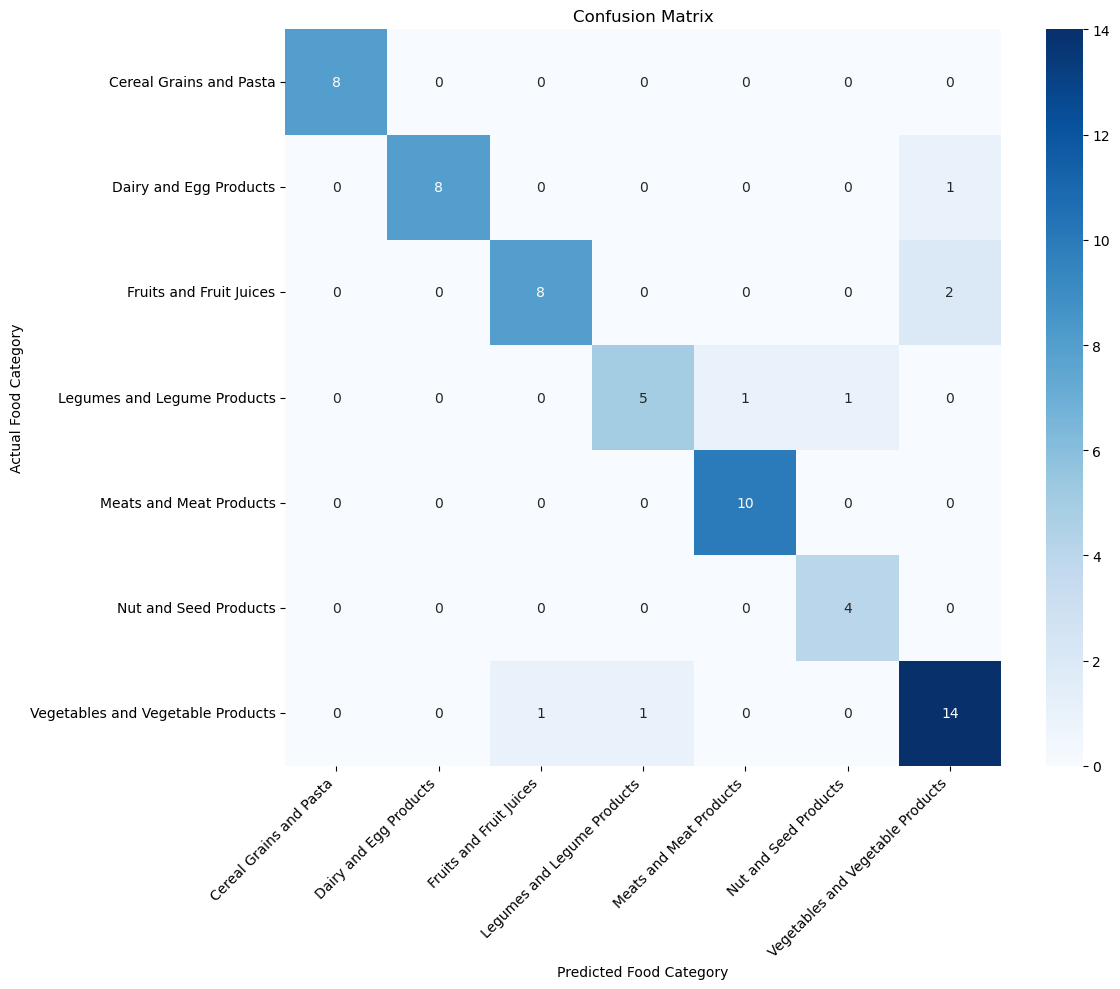

In [61]:
# Checks if training data is available
if 'X_train' in locals() and 'y_train' in locals() and not X_train.empty and not y_train.empty:
    print("--- Training the RandomForestClassifier ---")
    
    # Initialize the RandomForestClassifier
    model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
    
    # Train the model
    model.fit(X_train, y_train)
    
    print("Model training complete.")
    
    # Evaluating the Model
    print("\n--- Evaluating Model Performance on the Test Set ---")
    
    # Make predictions on the test set
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}")
    
    # Generate a classification report
    print("\nClassification Report:")
    # Get all unique labels that are present in either y_test or y_pred for the report

    report_labels = np.union1d(y_test.unique(), y_pred) 
    print(classification_report(y_test, y_pred, labels=report_labels, zero_division=0))
    
    # Generates and display the confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_pred, labels=report_labels)
    
    # Plotting the confusion matrix for better visualization
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", 
                xticklabels=report_labels, yticklabels=report_labels)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Food Category')
    plt.xlabel('Predicted Food Category')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

else:
    print("Error: Training data (X_train, y_train) not found. Please ensure the train-test split cell was run successfully.")

# Training k-nearest neighbour classifier

--- Training the K-Nearest Neighbors classifier ---
KNeighborsClassifier training complete.

--- Evaluating KNN Model Performance on the Test Set ---
KNN Test Set Accuracy: 0.7344

KNN Classifier - Classification Report:
                                   precision    recall  f1-score   support

          Cereal Grains and Pasta       0.80      1.00      0.89         8
           Dairy and Egg Products       0.71      0.56      0.62         9
          Fruits and Fruit Juices       0.58      0.70      0.64        10
      Legumes and Legume Products       0.67      0.57      0.62         7
          Meats and Meat Products       0.89      0.80      0.84        10
            Nut and Seed Products       0.67      0.50      0.57         4
Vegetables and Vegetable Products       0.76      0.81      0.79        16

                         accuracy                           0.73        64
                        macro avg       0.73      0.71      0.71        64
                     weight

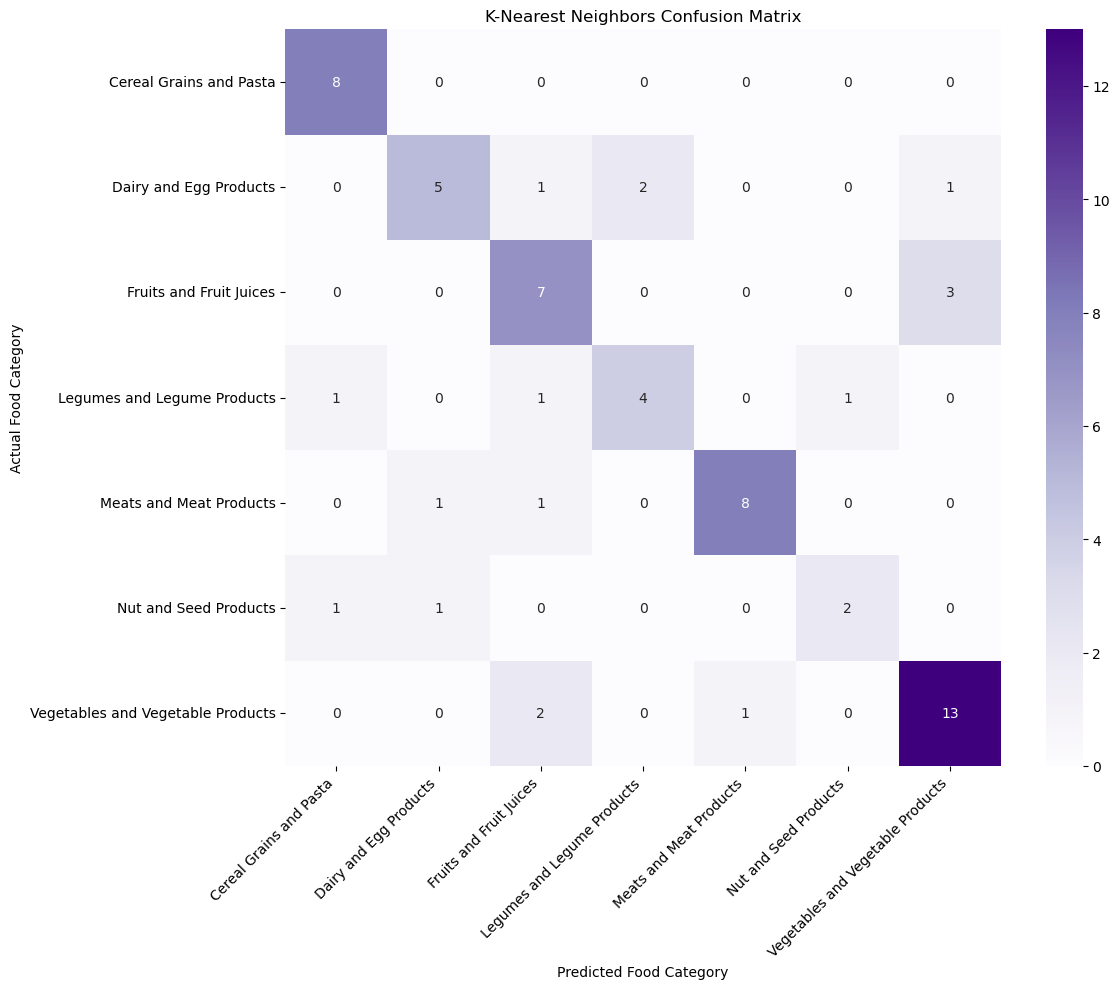

In [73]:
if 'X_train' in locals() and 'y_train' in locals() and not X_train.empty and not y_train.empty:
    print("--- Training the K-Nearest Neighbors classifier ---")
    
    # Training the model using n=5
    knn_model = KNeighborsClassifier(n_neighbors=5)
    knn_model.fit(X_train, y_train)
    print("KNeighborsClassifier training complete.")
    
    # Make preductions and calculate accuracy
    print("\n--- Evaluating KNN Model Performance on the Test Set ---")
    y_knn_pred = knn_model.predict(X_test)
    knn_accuracy = accuracy_score(y_test, y_knn_pred)
    print(f"KNN Test Set Accuracy: {knn_accuracy:.4f}")
    
    # Print classification report
    report_labels = np.union1d(y_test.unique(), y_knn_pred)
    print("\nKNN Classifier - Classification Report:")
    print(classification_report(y_test, y_knn_pred, labels=report_labels, zero_division=0))
    
    # Generate and display the confusion matrix
    print("\nConfusion Matrix:")
    cm = confusion_matrix(y_test, y_knn_pred, labels=report_labels)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", 
                xticklabels=report_labels, yticklabels=report_labels)
    plt.title('K-Nearest Neighbors Confusion Matrix')
    plt.ylabel('Actual Food Category')
    plt.xlabel('Predicted Food Category')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
else:
    print("Error: Training data (X_train, y_train) not found. Ensure the train-test split cell was run successfully.")